cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.71e+00 | test_loss: 5.25e+00 | reg: 4.10e+01 | : 100%|█| 20/20 [00:02<00:00,  7.44it


saving model version 0.1
MSE: 27.5187
RMSE: 5.2458
MAE: 3.5871
R²: 0.9854
fixing (0,0,0) with 0, r2=0.0, c=0
fixing (0,0,1) with cos, r2=0.9994763135910034, c=2
fixing (0,0,2) with x, r2=0.997917115688324, c=1
fixing (0,0,3) with cos, r2=0.99998939037323, c=2
fixing (0,0,4) with x, r2=0.9991175532341003, c=1
fixing (0,0,5) with x, r2=0.9988848567008972, c=1
fixing (0,1,0) with x, r2=1.0000003576278687, c=1
fixing (0,1,1) with x, r2=1.0000004768371582, c=1
fixing (0,1,2) with x, r2=1.0000003576278687, c=1
fixing (0,1,3) with x, r2=1.0000003576278687, c=1
fixing (0,1,4) with x, r2=0.9997198581695557, c=1
fixing (0,1,5) with x, r2=1.0000003576278687, c=1
fixing (0,2,0) with 0, r2=0.0, c=0
fixing (0,2,1) with 0, r2=0.0, c=0
fixing (0,2,2) with 0, r2=0.0, c=0
fixing (0,2,3) with 0, r2=0.0, c=0
fixing (0,2,4) with 0, r2=0.0, c=0
fixing (0,2,5) with 0, r2=0.0, c=0
fixing (0,3,0) with exp, r2=0.9990395903587341, c=2
fixing (0,3,1) with cos, r2=0.9999765157699585, c=2
fixing (0,3,2) with cos, r

62.953*x_1 + 0.056*x_2 - 0.863*x_5 + 0.848*x_6 - 114.315*(1 - 0.005*x_5)**2 - 0.078*exp(0.848*x_4) + 2.007*sin(1.81*x_4 - 7.605) - 0.025*cos(0.924*x_1 + 3.277) + 0.141*cos(0.487*x_4 + 3.795) + 93.203

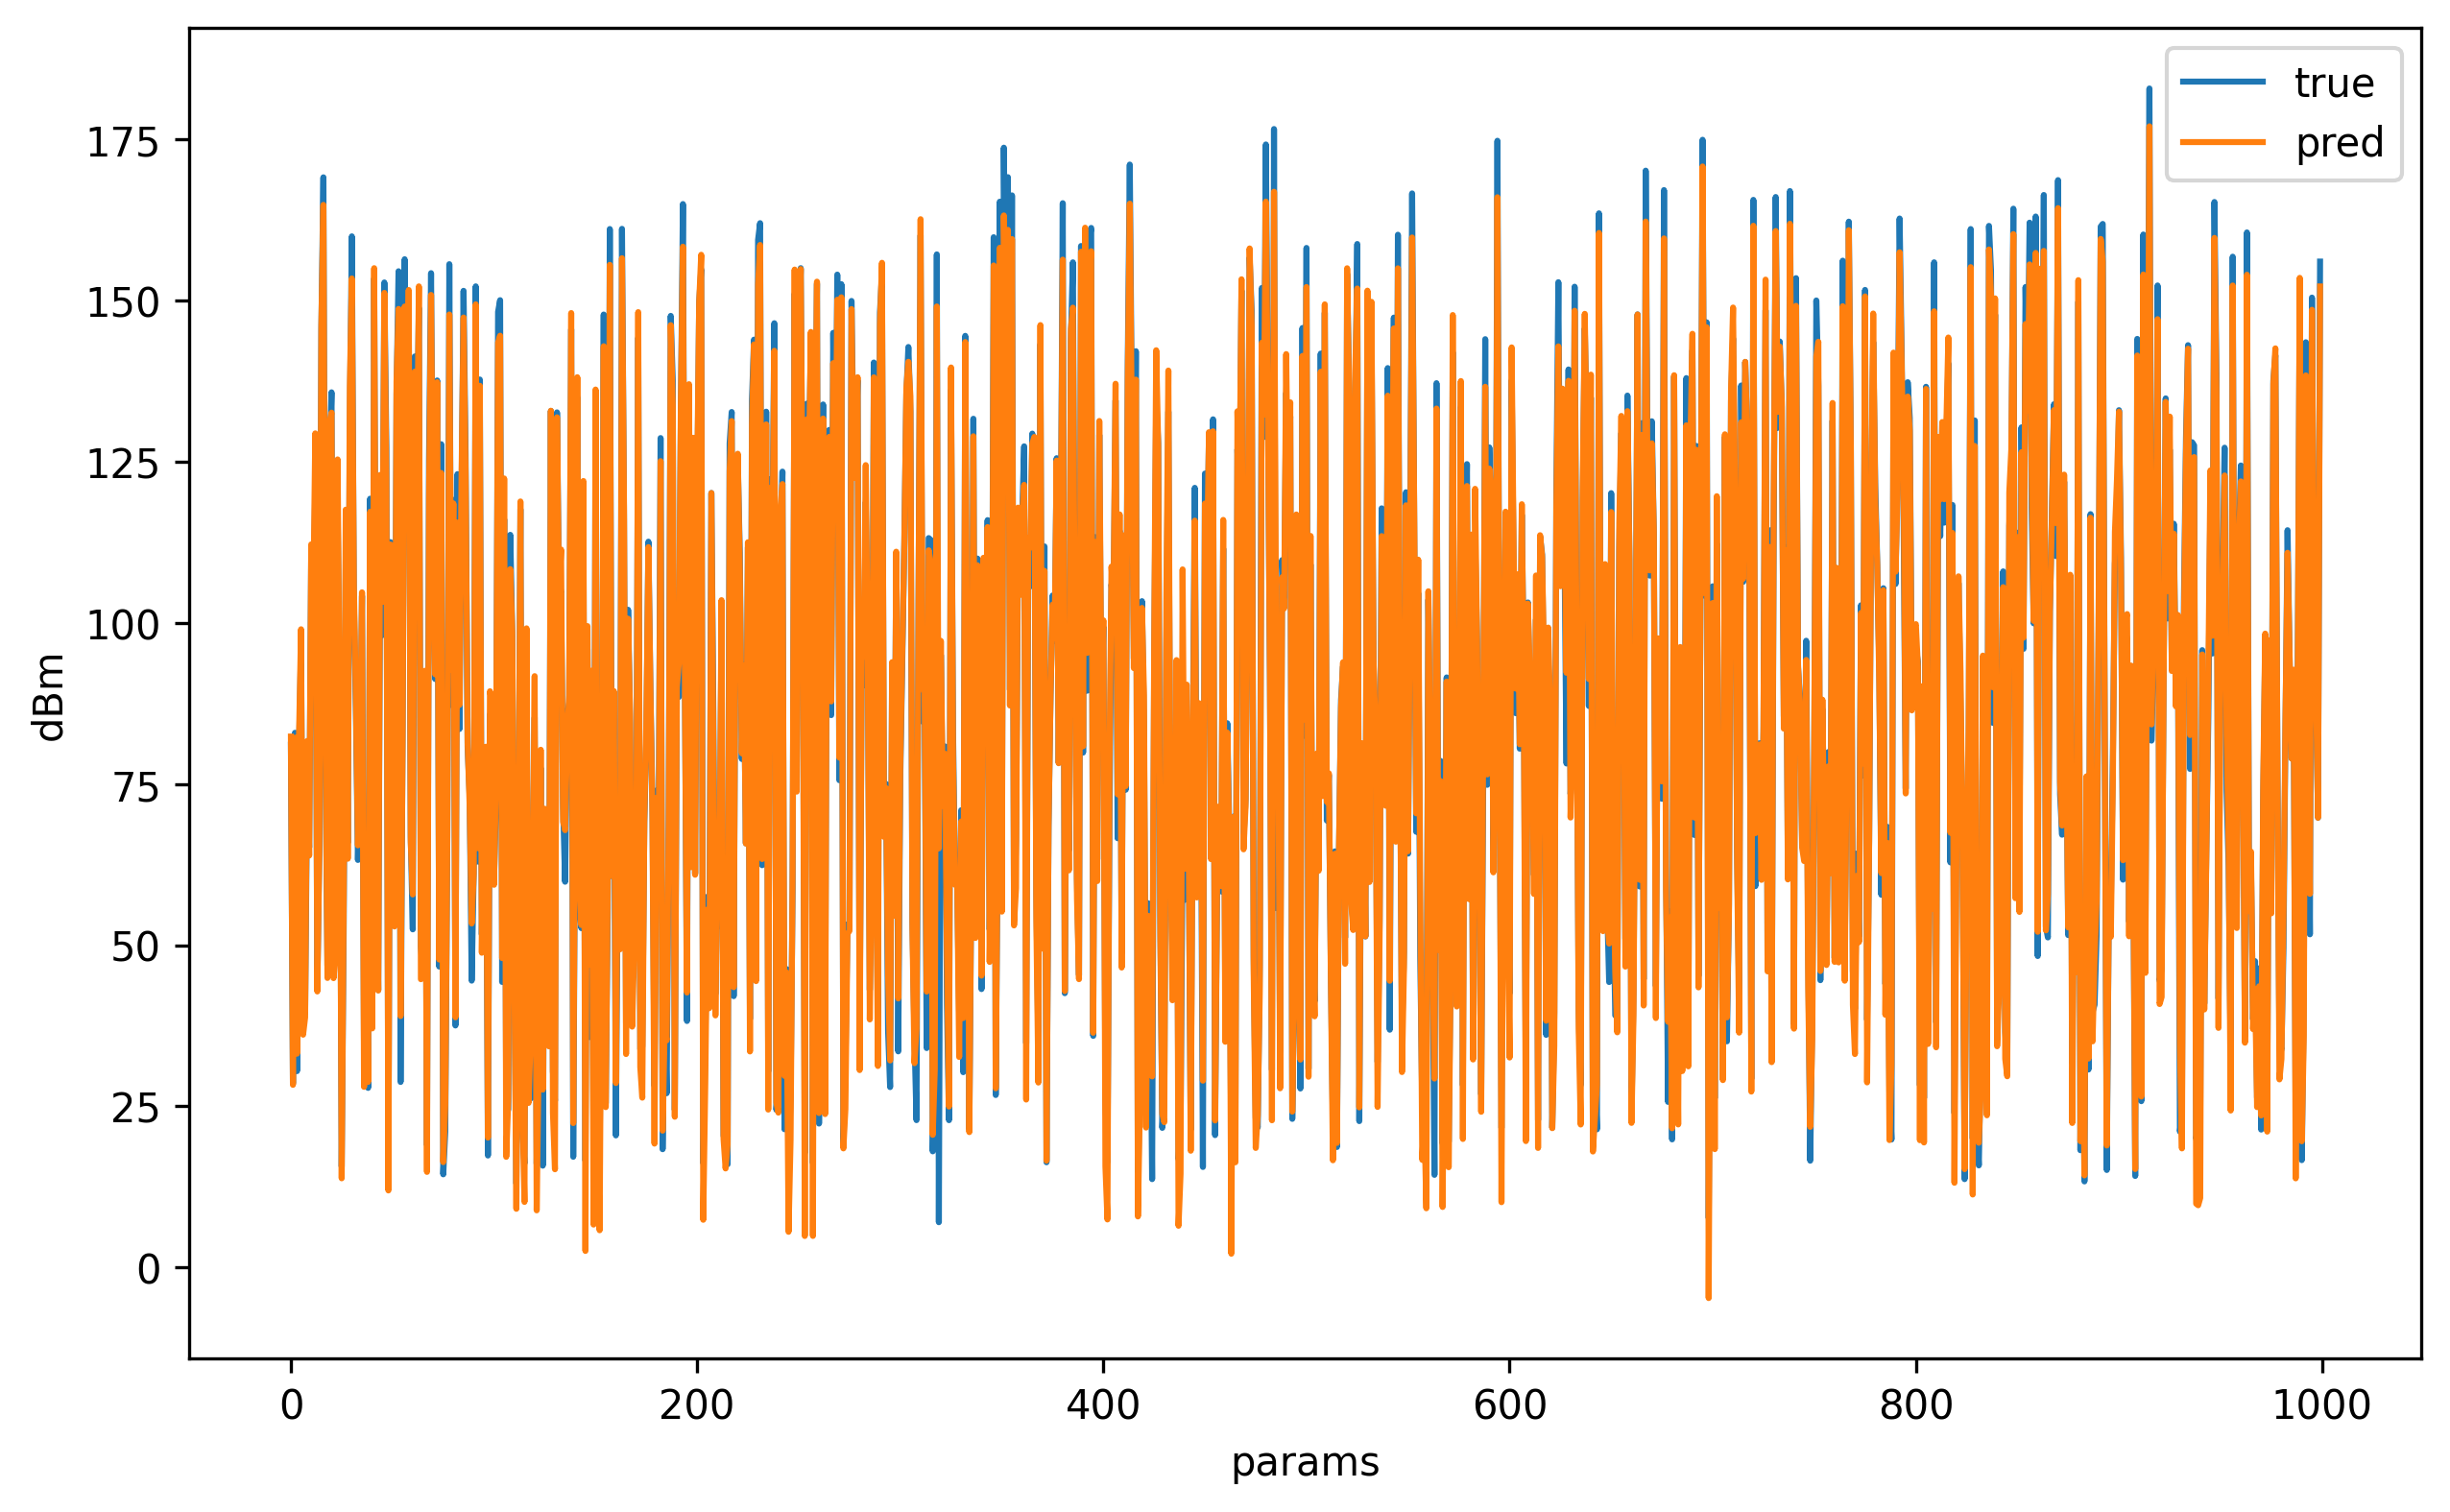

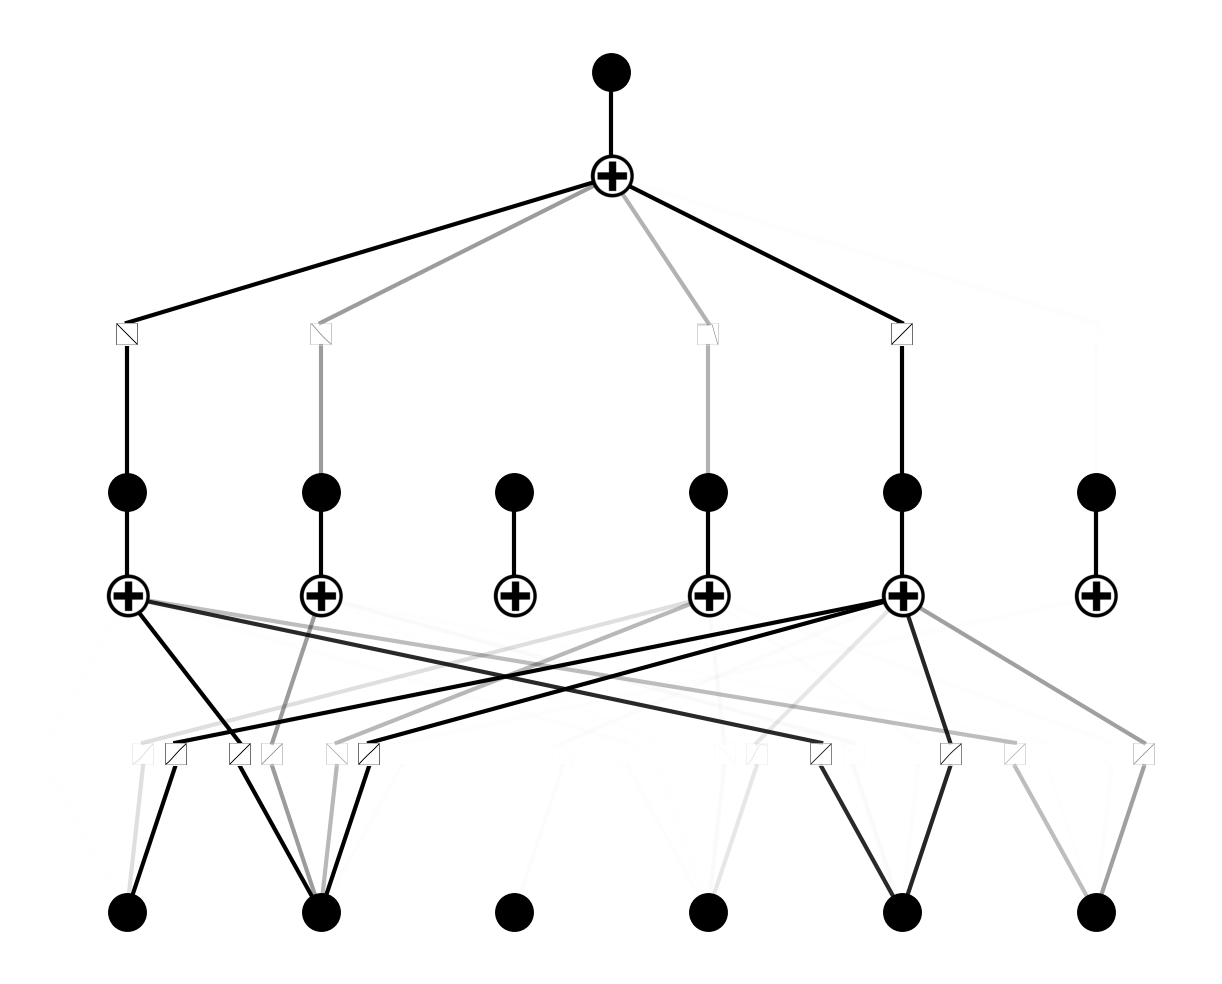

In [1]:

from kan import *
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def eval_kan(model_kan, test_data):
    y_true = test_data['test_label']
    with torch.no_grad():
        y_pred = model_kan(test_data['test_input'])
        
    y_true = y_true.detach().cpu().numpy().ravel()
    y_pred = y_pred.detach().cpu().numpy().ravel()
    time = range(len(y_true))

    # Plot the training and test losses.
    plt.plot(time, y_true)
    plt.plot(time, y_pred)
    plt.legend(['true', 'pred'])
    plt.ylabel('dBm')
    plt.xlabel('params')


    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mape = 0
    
    # Print results
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return mse, rmse, mae, mape, r2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gids_steps_lambda_loss(gids_size, steps, lam, metric, metric_name):
    """
    Plots a 3D scatter of gids_size vs steps vs train_loss, 
    with point color representing lambda.
    
    Parameters:
    - gids_size: array-like of shape (N,)
    - steps: array-like of shape (N,)
    - lam: array-like of shape (N,)
    - train_loss: array-like of shape (N,)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(gids_size, steps, lam, c=metric)
    
    ax.set_xlabel('gids size')
    ax.set_ylabel('steps')
    ax.set_zlabel('lambda')
    
    plt.colorbar(sc, label='metric')
    plt.title('3D Scatter: gids size vs steps vs lambda (' + metric_name + ' as color)')
    plt.show()


f = lambda x: 10 * x[:,[0]] * torch.log(2 * (x[:,[1]]) + x[:,[2]] + 10 * x[:,[3]] * torch.log(x[:,[4]])) + x[:,[5]]
dataset = create_dataset(f, 
                         n_var=6, 
                         ranges=[(0.1, 2.5), (1, 500), (-10,-1), (0,2), (2,73), (4,12)], 
                         #train_num=5000,
                         device=device)

model = KAN(width=[6,6,1], grid=3, k=3, seed=42, device=device)

model.fit(dataset, opt="LBFGS", steps=20, lamb=0.002, lamb_entropy=2.);

eval_kan(model, dataset)
model.plot()

model.auto_symbolic()

ex_round(model.symbolic_formula()[0][0], 3)
